In [14]:
import os
import sys
import numpy as np
import scipy.io.wavfile as wav
import time
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib notebook

In [15]:
# load the .wav file

sample_rate, samples = wav.read('happy.wav')

########### OPTIONAL ####################
# # ADAPT THIS TO YOUR OWN RECORDING
# start_ind = int(round(.5*len(samples)))
# end_ind = int(round(.95*len(samples)))
# samples = samples[start_ind:end_ind]
#########################################

n_samples = len(samples)

In [16]:
def windowing(signal,sample_rate,frame_size, window_fun = np.hanning, overlap = 0.5):

    '''
    Perform windowing of a signal.
    
    Returns frames of the signal mutiplied by the chosen window.
    '''
    
    if frame_size > len(samples):
        print('Be careful, your frame size is larger than your sample size')
    
    n_samples = len(samples)
    length = n_samples/sample_rate
    t = np.linspace(0,length,n_samples)
    dt = t[1]
    
    window = window_fun(frame_size)
    
    stride_length = int(frame_size - np.floor(overlap*frame_size))

    # append zeros at beginning of the domain 
    # so that the crest of the 1st window coindices with the first sample
    samples_left_pad = np.append(np.zeros(int(np.floor(frame_size/2.0)) ), samples)   

    t_left_pad = np.append(np.linspace(-int(np.floor(frame_size/2.0))*dt,
                                       -t[1],int(np.floor(frame_size/2.0))),t)

    # number of windowing frames
    n_frames = int(np.ceil((len(samples_left_pad) - frame_size) / float(stride_length))) + 1

    # append zeros at the end of the domain in case the window oversteps the boundary
    samples_pad = np.append(samples_left_pad, np.zeros(int(np.ceil(frame_size/2.0)) ))

    t_pad = np.append(t_left_pad, 
                      np.linspace(t[-1],t[-1]+int(np.ceil(frame_size/2.0))*dt,
                                  int(np.ceil(frame_size/2.0)) ))

    frames = np.lib.stride_tricks.as_strided(samples_pad, 
                                             shape=(n_frames, frame_size), 
                                             strides=(samples_pad.strides[0]*stride_length, 
                                             samples_pad.strides[0])).copy()    
    
    return window*frames

Note:

[complex128](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.types.html?highlight=complex128) is a data type, use to represent complex numbers with 64-bit floats.

In [24]:
frame_size = 2**10
window_frames = windowing(samples,sample_rate,frame_size)
fr = 20
sfft = np.fft.fft(window_frames)
print(sfft.shape)
n_frames = sfft.shape[0]

factor=1.0

scale = np.linspace(0, 1, frame_size) ** factor
scale *= (frame_size-1)/max(scale)   
scale = np.unique(np.round(scale).astype(int))


# create spectrogram with new freq bins
newspec = np.complex128(np.zeros([n_frames, len(scale)]))
for i in range(0, len(scale)):
    if i == len(scale)-1:
        newspec[:,i] = np.sum(sfft[:,scale[i]:], axis=1)
    else:        
        newspec[:,i] = np.sum(sfft[:,scale[i]:scale[i+1]], axis=1)

# list center freq of bins
allfreqs = np.abs(np.fft.fftfreq(frame_size*2, 1./sample_rate)[:frame_size+1])
freqs = []
for i in range(0, len(scale)):
    if i == len(scale)-1:
        freqs += [np.mean(allfreqs[scale[i]:])]
    else:
        freqs += [np.mean(allfreqs[scale[i]:scale[i+1]])]

(28, 1024)


<IPython.core.display.Javascript object>


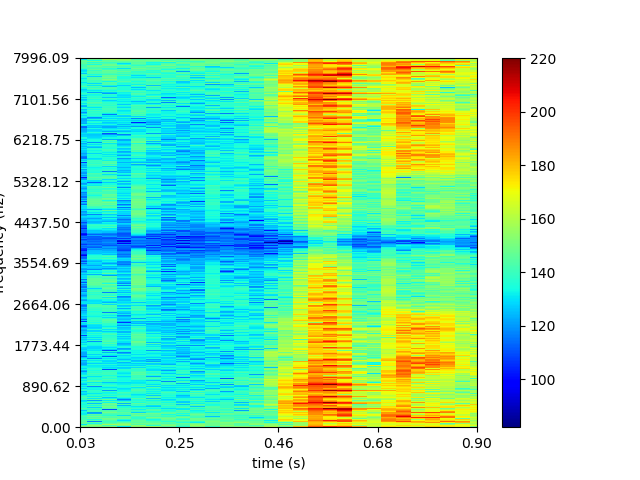

([<matplotlib.axis.YTick at 0x7faf3f50d080>,
 <a list of 10 Text yticklabel objects>)

In [25]:
colormap = 'jet'

ims = 20.*np.log10(np.abs(newspec)/10e-6) # amplitude to decibel

timebins, freqbins = np.shape(ims)

plt.subplots()
#plt.figure(figsize=(15, 7.5))
plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
plt.colorbar()

plt.xlabel("time (s)")
plt.ylabel("frequency (hz)")
plt.xlim([0, timebins-1])
plt.ylim([0, freqbins])

xlocs = np.float32(np.linspace(0, timebins-1, 5))
plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*frame_size))/sample_rate])
ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
plt.yticks(ylocs, ["%.02f" % freqs[i] for i in ylocs])